**Autor:R.** Hurtado                  

**Materia:** Procesamiento de Datos
                            
**Topico:** Introduccion a PySpark en el Ambiente Databricks

**Contenido:** Limpieza y Breve Analisis de Datos sobre personas que han sufriendo de un accidente cerebrovascular

# Extraccion de Datos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import SQLContext

In [ ]:
# Se crea una SparkSession
spark = SparkSession.builder \
    .appName("SparkEnvironment") \
    .getOrCreate()

In [15]:
from google.colab import drive
drive.mount('/content/drive')

# Ruta al archivo CSV en Google Drive
Stroke_File_path = "/content/drive/MyDrive/Colab Notebooks/EXTRA/Prosesamiento datos Datasets/stroke_pyspark.csv"

# Crea un DataFrame de Spark a partir del archivo CSV
df00 = spark.read.csv(Stroke_File_path, header=True, inferSchema=True)

# Muestra las primeras filas del DataFrame
df00.show(5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|  

In [16]:
df00.columns

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

###  Que Datos Contiene el Datafame

`id`: un número único para identificar a cada persona.

`gender`: género de la persona (`Male`, `Female`, `Other`).

`age`: edad en años.

`hypertension`: si tiene presión alta (0 = No, 1 = Sí).

`heart_disease`: si tiene alguna enfermedad del corazón (0 = No, 1 = Sí).

`ever_married`: si alguna vez se ha casado (`Yes` o `No`).

`work_type`: a qué se dedica (`Private`, `Self-employed`, `Govt_job`, `children`, etc.).

`Residence_type`: si vive en zona urbana o rural.

`avg_glucose_level`: nivel promedio de glucosa en sangre.

`bmi`: índice de masa corporal (relación entre peso y estatura).

`smoking_status`: si fuma o ha fumado (`smokes`, `never smoked`, `formerly smoked`, etc.).

`stroke`: si ha tenido un ACV (accidente cerebrovascular) (0 = No, 1 = Sí).


In [17]:
df00.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



como se puede observar, hay datos numericos son del tipo string

In [18]:
#Se cambian los datos "age" y "bmi" de string a Int y Double
df01 = df00.withColumn("age", df00.age.cast("int"))
df01 = df00.withColumn("bmi", df00.bmi.cast("double"))
df01.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [19]:
#Cuantas entradas hay por Genero
df01.groupBy('gender').count().show()


+------+-----+
|gender|count|
+------+-----+
|Female| 2994|
| Other|    1|
|  Male| 2115|
+------+-----+



In [23]:
# se eliminar 'other' de la columna gender porque al ser solo un dato no contribuye al analisis

# Eliminar filas donde 'gender' es 'Other'
df01 = df01.filter(df01.gender != 'Other')

# Mostrar el recuento de entradas por género después de eliminar 'Other'
df01.groupBy('gender').count().show()


+------+-----+
|gender|count|
+------+-----+
|Female| 2994|
|  Male| 2115|
+------+-----+





```
# Tiene formato de código
```

# REVISION DE DATOS NULOS Y LIMPIEZA

In [24]:
df01.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|201|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



se encuentra que solo hay datos Nulos en la columba BMI por lo que se remplazara el valor nulo por el su BMI promedio por peso y rango de edades

In [25]:
# se recolectan los Promedios de el imc

rangos = [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90)]



def calcular_promedio_imc(df, gender, rangos):
    promedios = {}
    for start, end in rangos:
        key = f'avg{end}{gender[0]}'

        avg = df.filter((col('gender') == gender) & (col('age') >= start) & (col('age') < end)) \
                .agg(F.mean(col('bmi'))).collect()[0][0]

        promedios[key] = avg

    return promedios

# Calcular los promedios para mujeres y hombres
resultadosF = calcular_promedio_imc(df01, 'Female', rangos)
print(resultadosF)

resultadosM = calcular_promedio_imc(df01, 'Male', rangos)
print(resultadosM)

{'avg10F': 18.687962962962963, 'avg20F': 25.202371541501993, 'avg30F': 28.110054347826086, 'avg40F': 31.114250614250615, 'avg50F': 31.147260273972595, 'avg60F': 31.64794816414686, 'avg70F': 30.777976190476185, 'avg80F': 29.53778501628664, 'avg90F': 28.23577981651375}
{'avg10M': 19.03168724279836, 'avg20M': 24.584051724137947, 'avg30M': 28.228823529411773, 'avg40M': 31.372321428571432, 'avg50M': 31.936329588014974, 'avg60M': 31.889181286549697, 'avg70M': 31.3031496062992, 'avg80M': 29.140291262135918, 'avg90M': 28.34931506849315}


In [26]:
#remplazar NULL por promedios por su rango de edad

promedios = {**resultadosF, **resultadosM}

def remplazar_nulls(df, promedios, rangos):
    for start, end in rangos:
        for gender in ['Female', 'Male']:
            key = f'avg{end}{gender[0]}'
            avg_bmi = promedios.get(key, None)

            # Asegurarse de que el promedio no sea None
            if avg_bmi is not None:
                # Reemplazar los valores NULL de BMI con el promedio calculado para ese grupo
                df = df.withColumn(
                    'bmi',
                    F.when(
                        (F.col('gender') == gender) &
                        (F.col('age') >= start) & (F.col('age') < end) &
                        F.col('bmi').isNull(), avg_bmi
                    ).otherwise(F.col('bmi'))
                )
    return df


df02 = remplazar_nulls(df01, promedios, rangos)

In [27]:
#Se visualiza si aun existen datos nulos
df02.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df02.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



# Visualizacion e Analisis de datos

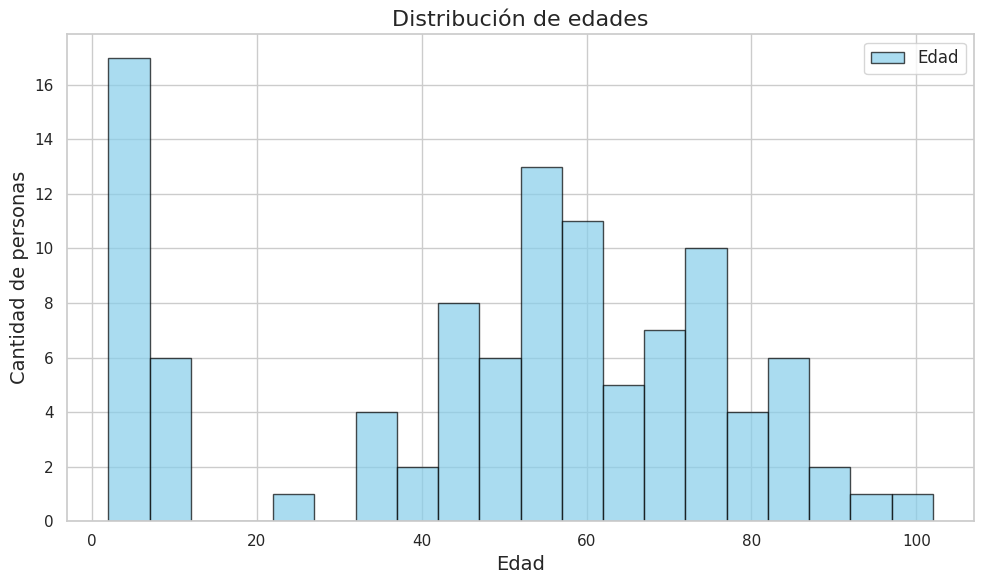

In [29]:
#Grafico de Distribucion por Edades

sns.set(style="whitegrid")

clases, cantidad = df02.groupby('age').count().select('count').rdd.flatMap(lambda x: x).histogram(20)
plt.figure(figsize=(10, 6))
plt.hist(clases[:-1], bins=clases, weights=cantidad, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribución de edades', fontsize=16)
plt.xlabel('Edad', fontsize=14)
plt.ylabel('Cantidad de personas', fontsize=14)
plt.legend(['Edad'], loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

Hay una cantida alta de personas muy jovenes entre los datos con edades menores a los 10 años aproximadamente

apartir de los 20 años las edades parecen asemejarse a una distribucion normal

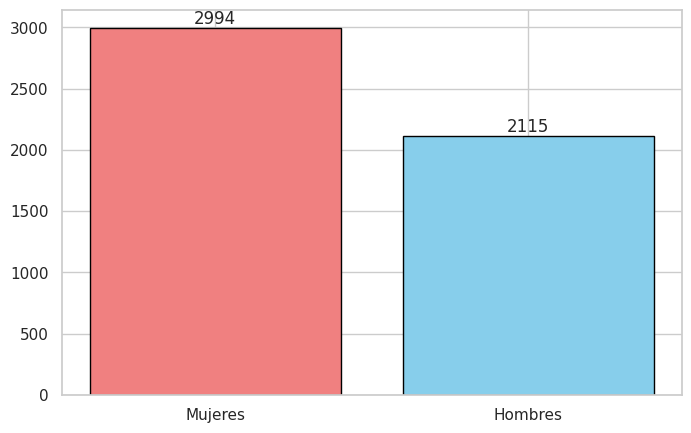

In [34]:
## Conteo por genero

sns.set(style="whitegrid")
genero = df02.groupby('gender').count().select('count').rdd.flatMap(lambda x: x).collect()

categoria = ['Mujeres', 'Hombres']

plt.figure(figsize=(8, 5))
grafica = plt.bar(categoria, genero, color=['lightcoral', 'skyblue'], edgecolor='black')

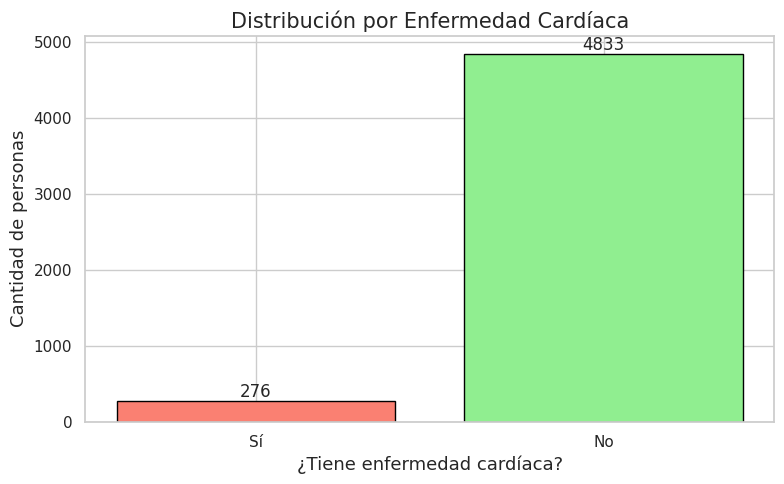

In [32]:
## Cantidad de personas con enfermedades cardiacas

sns.set(style="whitegrid")

enfCardiaca = df02.groupby('heart_disease').count().select('count').rdd.flatMap(lambda x: x).collect()
categorias = ['Sí', 'No']

plt.figure(figsize=(8, 5))
grafica = plt.bar(categorias, enfCardiaca, color=['salmon', 'lightgreen'], edgecolor='black')

plt.ylabel('Cantidad de personas', fontsize=13)
plt.xlabel('¿Tiene enfermedad cardíaca?', fontsize=13)
plt.title('Distribución por Enfermedad Cardíaca', fontsize=15)

plt.tight_layout()
plt.show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4860|
+------+-----+



<ipython-input-41-a195f64e28cf>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stroke_categories, y=stroke_values, palette='pastel', edgecolor='black')


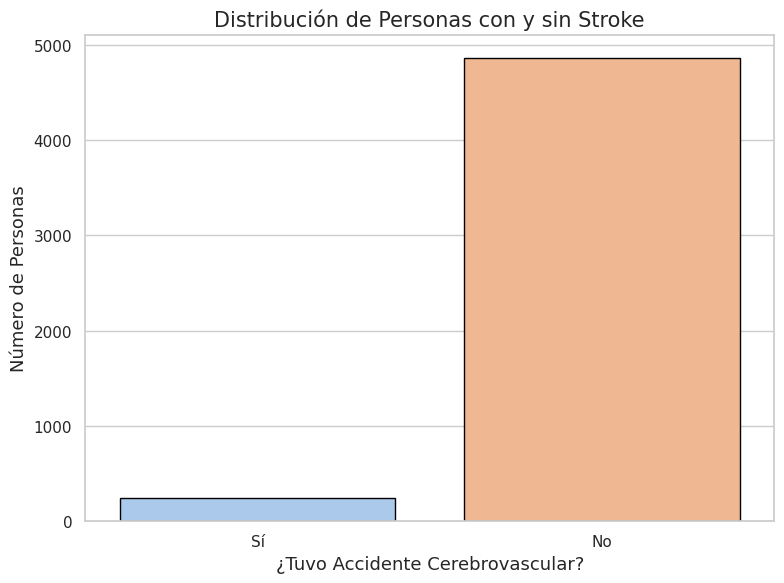

In [41]:
# grafica de si la persona ha tenido un accidente cardiovascular

sns.set(style="whitegrid")

df02.groupBy('stroke').count().show()
stroke_counts = df02.groupBy('stroke').count().collect()

stroke_categories = ['No', 'Sí'] if stroke_counts[0]['stroke'] == 0 else ['Sí', 'No']
stroke_values = [row['count'] for row in stroke_counts]

plt.figure(figsize=(8, 6))
sns.barplot(x=stroke_categories, y=stroke_values, palette='pastel', edgecolor='black')
plt.xlabel('¿Tuvo Accidente Cerebrovascular?', fontsize=13)
plt.ylabel('Número de Personas', fontsize=13)
plt.title('Distribución de Personas con y sin Stroke', fontsize=15)

plt.tight_layout()
plt.show()



In [44]:
#se crea df03 con personas que hayan sufrido accidentes cardiovasculares
df03 = df02.filter(df02.stroke == 1)
df03.show(5)


+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+------------------+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|               bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+------------------+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|              36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|30.777976190476185|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|              32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|

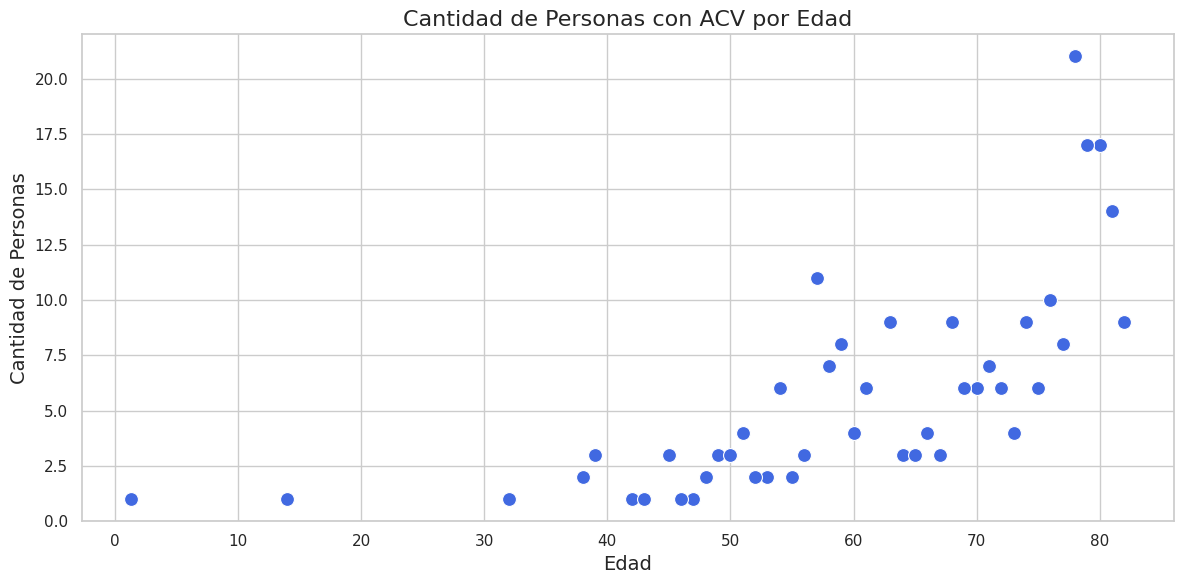

In [49]:
# grafico de edades de personas que sufrieron un accidente cardiovascular

sns.set(style="whitegrid")
edades_conteo = df03.groupBy('age').count().toPandas()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=edades_conteo, x='age', y='count', color='royalblue', s=100)

plt.title('Cantidad de Personas con ACV por Edad', fontsize=16)
plt.xlabel('Edad', fontsize=14)
plt.ylabel('Cantidad de Personas', fontsize=14)
plt.tight_layout()
plt.show()



a pesar de que si hayan casos de ataques cardiacos a personas menores a 20, las ocurrencias comienzan a incrementar entre los 45 y 55 años. la mayoria siendo ya personas en la tercera edad

In [53]:
media = df03.select(F.mean('age')).collect()[0][0]
mediana = df03.approxQuantile('age', [0.5], 0.01)[0]

print(f"Media de la edad: {media}")
print(f"Mediana de la edad: {mediana}")

Media de la edad: 67.72819277108434
Mediana de la edad: 71.0


In [66]:
# Se calcula correlacion entre BMI y Stroke
correlation1 = df02.corr('bmi', 'stroke')

print(f"Correlation between BMI and Stroke: {correlation1}")

Correlation between BMI and Stroke: 0.0424194755353266


al Ser Stroke una variable booleana es mas dificil calcular la correlacion de esta manera por lo que toca intentar otros metodos para poder sacar conclusiones acertadas sobre la relacion entre las dos variables.
no se puede observar una alta correlacion entre BMI y Stroke

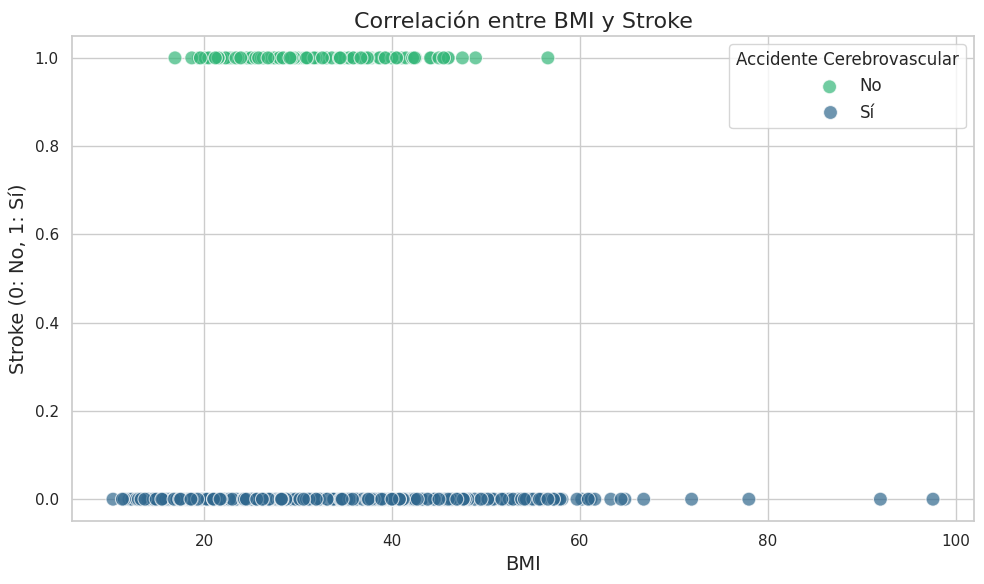

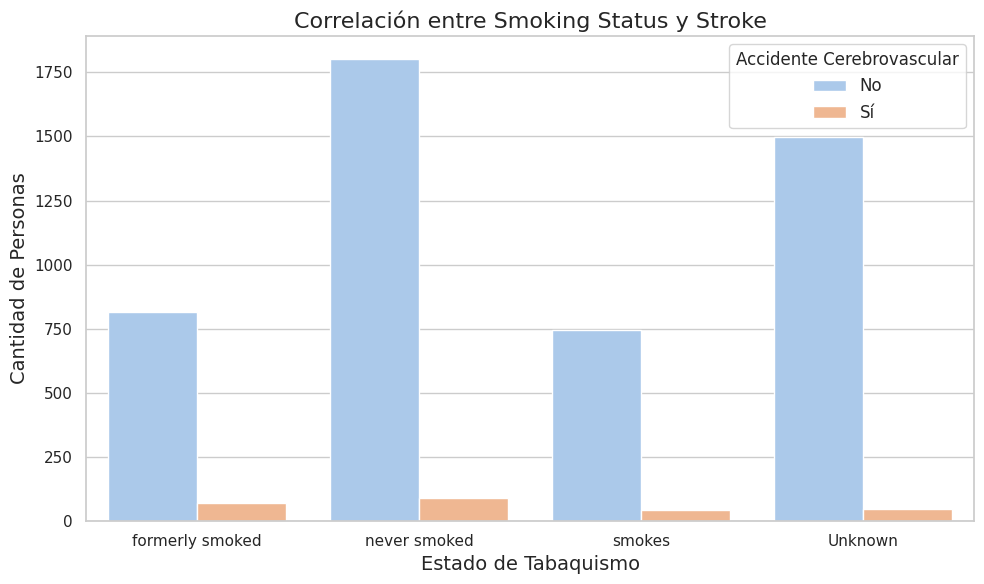

In [65]:
# Se Convierte el PySpark DataFrame a un Pandas DataFrame
df02_pd = df02.toPandas()

# Configuración para los gráficos
sns.set(style="whitegrid")

# 1. Visualizar la correlación entre 'bmi' y 'stroke' usando un scatterplot
plt.figure(figsize=(10, 6))
# Use the converted Pandas DataFrame 'df02_pd' here
sns.scatterplot(x='bmi', y='stroke', data=df02_pd, hue='stroke', palette='viridis', s=100, alpha=0.7)
plt.title('Correlación entre BMI y Stroke', fontsize=16)
plt.xlabel('BMI', fontsize=14)
plt.ylabel('Stroke (0: No, 1: Sí)', fontsize=14)
plt.legend(title='Accidente Cerebrovascular', labels=['No', 'Sí'], fontsize=12)
plt.tight_layout()
plt.show()

# 2. Visualizar la correlación entre 'smoking_status' y 'stroke' usando un gráfico de barras
plt.figure(figsize=(10, 6))
# Use the converted Pandas DataFrame 'df02_pd' here as well
sns.countplot(x='smoking_status', hue='stroke', data=df02_pd, palette='pastel')
plt.title('Correlación entre Smoking Status y Stroke', fontsize=16)
plt.xlabel('Estado de Tabaquismo', fontsize=14)
plt.ylabel('Cantidad de Personas', fontsize=14)
plt.legend(title='Accidente Cerebrovascular', labels=['No', 'Sí'], fontsize=12)
plt.tight_layout()
plt.show()

In [73]:
# proporcion de conteo de personas fuman

smoking_status_counts = df02.groupBy("smoking_status").count().collect()
total_count = df02.count()

smoking_proportions = {}
for row in smoking_status_counts:
    status = row["smoking_status"]
    count = row["count"]
    proportion = count / total_count
    smoking_proportions[status] = proportion
    print(f"Proportion of people who {status}: {proportion:.2f}")


Proportion of people who smokes: 0.15
Proportion of people who Unknown: 0.30
Proportion of people who never smoked: 0.37
Proportion of people who formerly smoked: 0.17


In [69]:
# Conteo personas que fuman con ataques cardiovasculares con personas que no fuman

smoker_stroke_counts = df02.groupBy("smoking_status", "stroke").count()
smoker_stroke_counts.show()

stroke_patients = df02.filter(df02.stroke == 1)
smoker_counts = stroke_patients.groupBy("smoking_status").count()
smoker_counts.show()

total_strokes = stroke_patients.count()

smoker_percentages = smoker_counts.withColumn(
    "percentage", (col("count") / total_strokes) * 100
)
smoker_percentages.show()


+---------------+------+-----+
| smoking_status|stroke|count|
+---------------+------+-----+
|formerly smoked|     1|   70|
|   never smoked|     1|   90|
|        Unknown|     0| 1497|
|         smokes|     1|   42|
|        Unknown|     1|   47|
|   never smoked|     0| 1802|
|formerly smoked|     0|  814|
|         smokes|     0|  747|
+---------------+------+-----+

+---------------+-----+
| smoking_status|count|
+---------------+-----+
|         smokes|   42|
|        Unknown|   47|
|   never smoked|   90|
|formerly smoked|   70|
+---------------+-----+

+---------------+-----+------------------+
| smoking_status|count|        percentage|
+---------------+-----+------------------+
|         smokes|   42|16.867469879518072|
|        Unknown|   47| 18.87550200803213|
|   never smoked|   90|36.144578313253014|
|formerly smoked|   70| 28.11244979919679|
+---------------+-----+------------------+



puesto que la mayoria de personas no fuman dentro de los datos, no e puede concluir que haya una relacion clara entre fumar y ataques cardiovasculares por que los datos no son proporcionales, lo que indica que el analisis puede estar sesgado

Para Continuar el estudio se debe realizar un submuestro para balancear los datos, a continuacion se puede realizar un T-test para  realizar un análisis comparativo para  las medias de las personas que fuman y las que no fuman en relación con el stroke

In [82]:
from pyspark.sql.functions import count as count_

# Proporciones deseadas para cada categoría de "smoking_status"
proportions = {
    "never smoked": 0.25,
    "formerly smoked": 0.25,
    "smokes": 0.25,
    "Unknown": 0.25
}

# Obtener el total de registros en el DataFrame para evitar recalcularlo en cada iteración
total_count = df02.count()

# Crear un DataFrame vacío para almacenar las muestras balanceadas
sampled_df = None

# Submuestreo para cada categoría de smoking_status
for status, prop in proportions.items():
    # Filtrar el DataFrame por la categoría actual de smoking_status
    status_df = df02.filter(df02["smoking_status"] == status)

    # Calcular cuántos registros tomar según la proporción deseada
    n = int(prop * total_count)

    # Calcular el número de registros disponibles para esa categoría
    category_count = status_df.select(count_("*")).first()[0]

    # Calcular la fracción para el submuestreo, asegurándose de no exceder el número de registros disponibles
    fraction = n / float(category_count)  # Aquí no usamos `min()`

    # Si la fracción es mayor que 1, ajustarla a 1 (para evitar obtener más registros de los disponibles)
    if fraction > 1:
        fraction = 1.0

    # Realizar el submuestreo de esa categoría
    sample = status_df.sample(False, fraction)  # Realizamos el submuestreo

    # Unir la muestra con el DataFrame final
    if sampled_df is None:
        sampled_df = sample
    else:
        sampled_df = sampled_df.union(sample)

# Mostrar el número de registros por categoría después del submuestreo
sampled_df.groupBy("smoking_status").count().show()


+---------------+-----+
| smoking_status|count|
+---------------+-----+
|   never smoked| 1265|
|formerly smoked|  884|
|         smokes|  789|
|        Unknown| 1279|
+---------------+-----+



In [85]:
import scipy.stats as stats

# Convertir a pandas para el análisis (solo después de balancear el dataset)
df_pandas = sampled_df.select('stroke', 'smoking_status', 'bmi').toPandas()

# Separar por categorías de smoking_status
fumadores = df_pandas[df_pandas['smoking_status'] == 'smokes']
no_fumadores = df_pandas[df_pandas['smoking_status'] == 'never smoked']

# Realizar un t-test entre fumadores y no fumadores en cuanto a la variable stroke
t_stat, p_value = stats.ttest_ind(fumadores['stroke'], no_fumadores['stroke'])
print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: 0.18328628754808324, P-value: 0.8545915006893631


al ser el p valor mayor a 0.5 se puede afirmar que si hay una relacion entre las variables, lo que sugiere que fumar si podria ser un causante de problemas cardiovasculares 

In [92]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, when

# 1. Preparar los datos: selecciona las variables necesarias y transforma las categorías
df_prepared = sampled_df.withColumn("smoking_status_num",
                                    when(col("smoking_status") == "never smoked", 0)
                                    .when(col("smoking_status") == "formerly smoked", 1)
                                    .when(col("smoking_status") == "smokes", 2)
                                    .otherwise(3))

# 2. Selección de las características y la variable objetivo
assembler = VectorAssembler(inputCols=["bmi", "smoking_status_num"], outputCol="features")

# 3. Definir el modelo de regresión logística
lr = LogisticRegression(featuresCol="features", labelCol="stroke")

# 4. Dividir los datos en entrenamiento y prueba
train_data, test_data = df_prepared.randomSplit([0.8, 0.2], seed=1234)

# 5. Crear un Pipeline de entrenamiento
pipeline = Pipeline(stages=[assembler, lr]) # assembler is included in the pipeline

# 6. Entrenamiento del modelo
model = pipeline.fit(train_data)

# 7. Realizar predicciones
predictions = model.transform(test_data)

# 8. Evaluación del modelo: usar AUC para ver la calidad del modelo
evaluator = BinaryClassificationEvaluator(labelCol="stroke", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

print(f"AUC (Área bajo la curva ROC): {auc}")

# 9. Mostrar algunas predicciones para ver el rendimiento
predictions.select("stroke", "prediction", "probability").show(5)

AUC (Área bajo la curva ROC): 0.6133831742560797
+------+----------+--------------------+
|stroke|prediction|         probability|
+------+----------+--------------------+
|     0|       0.0|[0.94932237329127...|
|     1|       0.0|[0.93611876691692...|
|     0|       0.0|[0.94650357493722...|
|     0|       0.0|[0.92212160081341...|
|     0|       0.0|[0.93080110573047...|
|     0|       0.0|[0.92454678606390...|
|     0|       0.0|[0.93583595063226...|
|     1|       0.0|[0.93508662789781...|
|     0|       0.0|[0.93345019534855...|
|     0|       0.0|[0.89950339630465...|
|     0|       0.0|[0.93554725857506...|
|     0|       0.0|[0.94783696704887...|
|     0|       0.0|[0.89915873706685...|
|     0|       0.0|[0.93879681994838...|
|     0|       0.0|[0.94454285959135...|
|     0|       0.0|[0.94168401426632...|
|     0|       0.0|[0.94373978511045...|
|     0|       0.0|[0.94811857997574...|
|     0|       0.0|[0.92843504159827...|
|     0|       0.0|[0.94592233012291...|
+------+

El valor de AUC (Área bajo la Curva ROC) de 0.61 indica que el modelo tiene un rendimiento moderado. Este valor sugiere que el modelo tiene una capacidad algo mejor que el azar para distinguir entre las dos clases (si una persona sufrió un accidente cerebrovascular o no).

AUC = 0.5: El modelo no tiene capacidad de discriminación y está funcionando al nivel del azar.

AUC entre 0.5 y 0.7: El modelo tiene una discriminación débil.

AUC entre 0.7 y 0.9: El modelo tiene una buena capacidad de discriminación.

AUC > 0.9: El modelo tiene una excelente capacidad de discriminación.

En este caso, 0.61 indica que el modelo tiene una capacidad moderada, lo que es un buen punto de partida pero sugiere que puede ser necesario hacer ajustes adicionales para mejorar el rendimiento.